# Pickup to Delivery Overall

In [34]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import csv
import pickle
import matplotlib.pyplot as plt
from haversine import haversine, Unit
from sklearn.metrics.pairwise import haversine_distances, manhattan_distances
from sklearn.model_selection import train_test_split, cross_val_score

sys.path.insert(0, os.path.expanduser('./'))
import query_runner as qr
import utils
from estimator import BaselineModel_sum, BaselineModel_mean, LinearModel

In [35]:
base_query_path = './queries/'
dwh_config, livedb_config, parameters_config = utils.load_config(config_file='./config.ini')
datalake_connection = qr.create_connection(db='datalake')
#monolith_connection = qr.create_connection(user=livedb_config['monolith_username'], password=livedb_config['monolith_password'], db='livedb')
#dispatching_db_connection = qr.create_connection(user=livedb_config['dispatching_db_username'], password=livedb_config['dispatching_db_password'], db='dispatchingdb')

In [36]:
start_date = parameters_config['start_date']
end_date = parameters_config['end_date']
country_code = parameters_config['country_code']
cities = parameters_config['cities']

print(f'Start date: {start_date} | End date: {end_date} | Countries: {country_code} | Cities: {cities}')

Start date: 2024-09-30 | End date: 2024-10-20 | Countries: ES | Cities: 'MAD', 'BCN', 'SEV', 'ALC'


In [37]:
parameters = {
    'start_date': start_date,
    'end_date': end_date,
    'country_code': country_code,
    'cities': cities
}

## Load the data

In [38]:
query_name = '''
SELECT
    olf.country_code                                 AS country_code,
    olf.city_code                                    AS city_code,
    olf.order_id                                     AS order_id,
    olf.courier_id                                   AS courier_id,
    olf.order_created_local_datetime                 AS creation_timestamp,
    olf.order_activated_local_datetime               AS activation_timestamp,
    olf.courier_transport                            AS transport,
    olf.order_picked_up_local_datetime               AS pickup_timestamp,
    olf.order_arrival_to_delivery_local_datetime     AS delivery_entering_timestamp,
    olf.order_delivered_local_datetime               AS delivery_timestamp,
    olf.order_pickup_latitude                        AS pickup_latitude,
    olf.order_pickup_longitude                       AS pickup_longitude,
    olf.order_delivery_latitude                      AS delivery_latitude,
    olf.order_delivery_longitude                     AS delivery_longitude,
    olf.order_time_zone                              AS time_zone,
    olf.p_creation_date
FROM delta.courier_routing_courier_ml_features_odp.order_level_features AS olf
WHERE order_final_status = 'DeliveredStatus'
    AND order_number_of_assignments = 1
    AND order_bundle_index IS NULL
    AND p_creation_date >= DATE '[start_date]' AND p_creation_date < DATE '[end_date]'
    AND country_code IN ('[country_code]')
    AND city_code IN ([cities])
'''

query = qr.Query(base_query_path, query_name, datalake_connection, parameters_dict=parameters, query_from_file = False)

df = query.run()
df = df.fillna(value=np.nan)

data = df.copy()
data.head()

Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/cae9087f033f52b2195a66567aeb0585150d7f541f6842b100c7145df9cec5e2


,country_code,city_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_timestamp,delivery_entering_timestamp,delivery_timestamp,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,time_zone,p_creation_date
0,ES,BCN,100907487116,8590944,2024-10-03 20:55:02+00:00,2024-10-03 20:55:04+00:00,BICYCLE,2024-10-03 21:21:44.215000+00:00,2024-10-03 21:29:37+00:00,2024-10-03 21:32:33+00:00,41.370594,2.113433,41.375412,2.104837,Europe/Madrid,2024-10-03
1,ES,MAD,100907489425,162535288,2024-10-03 20:55:43+00:00,2024-10-03 20:55:44+00:00,BICYCLE,2024-10-03 21:07:40.941000+00:00,2024-10-03 21:16:09+00:00,2024-10-03 21:19:10+00:00,40.382927,-3.626392,40.383490,-3.640969,Europe/Madrid,2024-10-03
2,ES,BCN,100907493124,146788593,2024-10-03 20:56:48+00:00,2024-10-03 20:56:49+00:00,BICYCLE,2024-10-03 21:07:40.560000+00:00,2024-10-03 21:12:00+00:00,2024-10-03 21:14:30+00:00,41.389874,2.159761,41.390520,2.148718,Europe/Madrid,2024-10-03
3,ES,MAD,100907498582,45695767,2024-10-03 20:58:25+00:00,2024-10-03 20:58:26+00:00,MOTORBIKE,2024-10-03 21:08:59.224000+00:00,2024-10-03 21:11:21+00:00,2024-10-03 21:14:21+00:00,40.409720,-3.670494,40.412880,-3.671840,Europe/Madrid,2024-10-03
4,ES,MAD,100907503468,166385377,2024-10-03 20:59:51+00:00,2024-10-03 20:59:53+00:00,MOTORBIKE,2024-10-03 21:09:49.060000+00:00,2024-10-03 21:16:45+00:00,2024-10-03 21:20:30+00:00,40.433780,-3.683620,40.430176,-3.673502,Europe/Madrid,2024-10-03


## Clean the dataset

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 987012 entries, 0 to 87011
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype              
---  ------                       --------------   -----              
 0   country_code                 987012 non-null  object             
 1   city_code                    987012 non-null  object             
 2   order_id                     987012 non-null  int64              
 3   courier_id                   987012 non-null  int64              
 4   creation_timestamp           987012 non-null  datetime64[ns, UTC]
 5   activation_timestamp         987012 non-null  datetime64[ns, UTC]
 6   transport                    987012 non-null  object             
 7   pickup_timestamp             986757 non-null  datetime64[ns, UTC]
 8   delivery_entering_timestamp  972471 non-null  datetime64[ns, UTC]
 9   delivery_timestamp           987012 non-null  datetime64[ns, UTC]
 10  pickup_latitude              987012 no

In [40]:
data.describe()

,order_id,courier_id,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude
count,9.870120e+05,9.870120e+05,987012.000000,987012.000000,987012.000000,987012.000000
mean,1.009222e+11,1.218706e+08,40.673782,-0.851254,40.674140,-0.851210
std,1.301628e+07,5.590163e+07,0.993792,3.003208,0.993963,3.002620
min,1.008998e+11,1.127770e+05,37.282646,-6.085188,37.260975,-6.100339
25%,1.009108e+11,7.241826e+07,40.426132,-3.690008,40.426205,-3.689353
50%,1.009222e+11,1.482987e+08,40.530730,-0.483401,40.528835,-0.483956
75%,1.009337e+11,1.670841e+08,41.393280,2.159965,41.394840,2.159824
max,1.009444e+11,1.796540e+08,41.483086,2.268973,41.562153,2.277824


In [41]:
# Check for missing values
data.isnull().sum()

country_code                       0
city_code                          0
order_id                           0
courier_id                         0
creation_timestamp                 0
activation_timestamp               0
transport                          0
pickup_timestamp                 255
delivery_entering_timestamp    14541
delivery_timestamp                 0
pickup_latitude                    0
pickup_longitude                   0
delivery_latitude                  0
delivery_longitude                 0
time_zone                          0
p_creation_date                    0
dtype: int64

In [42]:
# print the number of null rows
data.isnull().sum().sum()

np.int64(14796)

In [43]:
# Remove rows with null values: we have many rows, so we can afford to remove them
data.dropna(inplace=True)

In [44]:
# Check for missing values
data.isnull().sum()

country_code                   0
city_code                      0
order_id                       0
courier_id                     0
creation_timestamp             0
activation_timestamp           0
transport                      0
pickup_timestamp               0
delivery_entering_timestamp    0
delivery_timestamp             0
pickup_latitude                0
pickup_longitude               0
delivery_latitude              0
delivery_longitude             0
time_zone                      0
p_creation_date                0
dtype: int64

In [45]:
# Check for duplicates
data.duplicated().sum()

np.int64(0)

## Compute new features

In [46]:
# Convert the creation time to datetime
data['creation_timestamp'] = pd.to_datetime(data['creation_timestamp'])
data['activation_timestamp'] = pd.to_datetime(data['activation_timestamp'])
data['pickup_timestamp'] = pd.to_datetime(data['pickup_timestamp'])
data['delivery_timestamp'] = pd.to_datetime(data['delivery_timestamp'])
data['delivery_entering_timestamp'] = pd.to_datetime(data['delivery_entering_timestamp'])

# Compute the delivery date and the delivery time
data['creation_date'] = data['creation_timestamp'].dt.date
data['creation_time'] = data['creation_timestamp'].dt.time
data['creation_hour'] = data['creation_timestamp'].dt.hour

To determine whether a coordinate is in degrees or radians, you can consider the typical ranges and values for latitude and longitude:
1. **Degrees:**
   - Latitude ranges from -90 to 90 degrees.
   - Longitude ranges from -180 to 180 degrees.
   - Values are typically whole numbers or decimals within these ranges.
2. **Radians:**
   - Latitude and longitude in radians will range from approximately -π/2 to π/2 for latitude and -π to π for longitude.
   - Values are typically small decimals (e.g., 0.5, 1.0, etc.).

Given our dataset, as the values in the columns `pickup_latitude`, `pickup_longitude`, `delivery_latitude`, `delivery_longitude` fall within the typical range for degrees, it is safe to assume that these coordinates are in degrees.

There is a difference in how the `haversine` library, the `sklearn`'s `haversine_distances`, and the `sklearn`'s `manhattan_distances` function compute and return the distances. Let's break down the differences and how to resolve them:
1. **Haversine Library:**
   - The `haversine` library directly computes the distance between two points and returns a single scalar value.
2. **Sklearn's `haversine_distances`:**
   - The `haversine_distances` function from `sklearn` returns a distance matrix. When you input two points, it returns a 1x1 matrix (a nested list) containing the distance. This is why you would see the result in squared parentheses like `[[]]`. We extract the single value using `[0][0]`.
   - To use these coordinates with sklearn's `haversine_distances` function, you need to convert them to radians using `np.radians`.
   - Additionally, the `haversine_distances` function returns the distance in radians, not in meters. To convert this to meters, you need to multiply by the Earth's radius (approximately 6371000 meters).
3. **Sklearn's `manhattan_distances`:**
   - The `manhattan_distances` function computes the Manhattan distance between two points and returns a distance matrix. We extract the single value from the 1x1 matrix using `[0][0]`.
   - Additionally, the `manhattan_distances` function from sklearn computes the distance based on the Cartesian coordinates provided. Since latitude and longitude are angular measurements, the result will not be in meters but in degrees. To convert the Manhattan distance from degrees to meters, you need to account for the Earth's curvature. 
      - The conversion factor for latitude is approximately 111,320 meters per degree.
      - The conversion factor for longitude varies based on the latitude. At the equator, it's approximately 111,320 meters per degree, but it decreases as you move towards the poles.
      - Convert the latitude and longitude differences to meters.
      - Sum the absolute differences to get the Manhattan distance in meters.

In [47]:
# Convert degrees to radians
data['pickup_latitude_rad'] = np.radians(data['pickup_latitude'])
data['pickup_longitude_rad'] = np.radians(data['pickup_longitude'])
data['delivery_latitude_rad'] = np.radians(data['delivery_latitude'])
data['delivery_longitude_rad'] = np.radians(data['delivery_longitude'])

# Earth's radius in meters
earth_radius_m = 6371.0088 * 1000  # average earth radius - https://en.wikipedia.org/wiki/Earth_radius#Mean_radius

# Conversion factors
meters_per_degree_lat = 111320  # Approximate meters per degree of latitude

def manhattan_distance_in_meters(row):
    # Convert latitude and longitude differences to meters
    lat_diff_m = abs(row['pickup_latitude'] - row['delivery_latitude']) * meters_per_degree_lat
    # Convert longitude difference to meters, considering the latitude
    lon_diff_m = abs(row['pickup_longitude'] - row['delivery_longitude']) * meters_per_degree_lat * np.cos(np.radians((row['pickup_latitude'] + row['delivery_latitude']) / 2))
    # Sum the absolute differences to get the Manhattan distance in meters
    return lat_diff_m + lon_diff_m

In [48]:
data['pd_distance_haversine_m'] = data.apply(
    lambda x: haversine(
        (x['pickup_latitude'], x['pickup_longitude']),
        (x['delivery_latitude'], x['delivery_longitude']),
        unit=Unit.METERS
    ), axis=1
)
data['pd_distance_haversine_m_sk'] = data.apply(
    lambda x: haversine_distances(
        np.array([[x['pickup_latitude_rad'], x['pickup_longitude_rad']]]),
        np.array([[x['delivery_latitude_rad'], x['delivery_longitude_rad']]])
    )[0][0] * earth_radius_m, axis=1
)
data['pd_distance_manhattan_m'] = data.apply(manhattan_distance_in_meters, axis=1)
data.head()

,country_code,city_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_timestamp,delivery_entering_timestamp,delivery_timestamp,...,creation_date,creation_time,creation_hour,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m
0,ES,BCN,100907487116,8590944,2024-10-03 20:55:02+00:00,2024-10-03 20:55:04+00:00,BICYCLE,2024-10-03 21:21:44.215000+00:00,2024-10-03 21:29:37+00:00,2024-10-03 21:32:33+00:00,...,2024-10-03,20:55:02,20,0.722053,0.036886,0.722137,0.036736,895.267385,895.267385,1254.424177
1,ES,MAD,100907489425,162535288,2024-10-03 20:55:43+00:00,2024-10-03 20:55:44+00:00,BICYCLE,2024-10-03 21:07:40.941000+00:00,2024-10-03 21:16:09+00:00,2024-10-03 21:19:10+00:00,...,2024-10-03,20:55:43,20,0.704815,-0.063292,0.704825,-0.063547,1236.264251,1236.264251,1298.738405
2,ES,BCN,100907493124,146788593,2024-10-03 20:56:48+00:00,2024-10-03 20:56:49+00:00,BICYCLE,2024-10-03 21:07:40.560000+00:00,2024-10-03 21:12:00+00:00,2024-10-03 21:14:30+00:00,...,2024-10-03,20:56:48,20,0.722390,0.037695,0.722401,0.037502,924.017061,924.017061,994.168407
3,ES,MAD,100907498582,45695767,2024-10-03 20:58:25+00:00,2024-10-03 20:58:26+00:00,MOTORBIKE,2024-10-03 21:08:59.224000+00:00,2024-10-03 21:11:21+00:00,2024-10-03 21:14:21+00:00,...,2024-10-03,20:58:25,20,0.705283,-0.064062,0.705338,-0.064086,369.394256,369.394256,465.858447
4,ES,MAD,100907503468,166385377,2024-10-03 20:59:51+00:00,2024-10-03 20:59:53+00:00,MOTORBIKE,2024-10-03 21:09:49.060000+00:00,2024-10-03 21:16:45+00:00,2024-10-03 21:20:30+00:00,...,2024-10-03,20:59:51,20,0.705703,-0.064291,0.705640,-0.064115,945.506113,945.506113,1258.537546


In [49]:
# print the number of null rows
data.isnull().sum().sum()

np.int64(0)

## Save the dataset

It's better to use the parquet format, as it is more efficient and faster to read and write. Besides, it is a columnar format, which is more suitable for analytical queries. We can also partition the data by creation date and city, which will help to speed up the queries and allows to analyze different timeframes and different cities if needed.

In [50]:
data.to_parquet("data/dataframe.parquet", index=False, partition_cols=['creation_date', 'city_code'])

## Exploratory Data Analysis (EDA)

In [51]:
data = pd.read_parquet("data/dataframe.parquet")

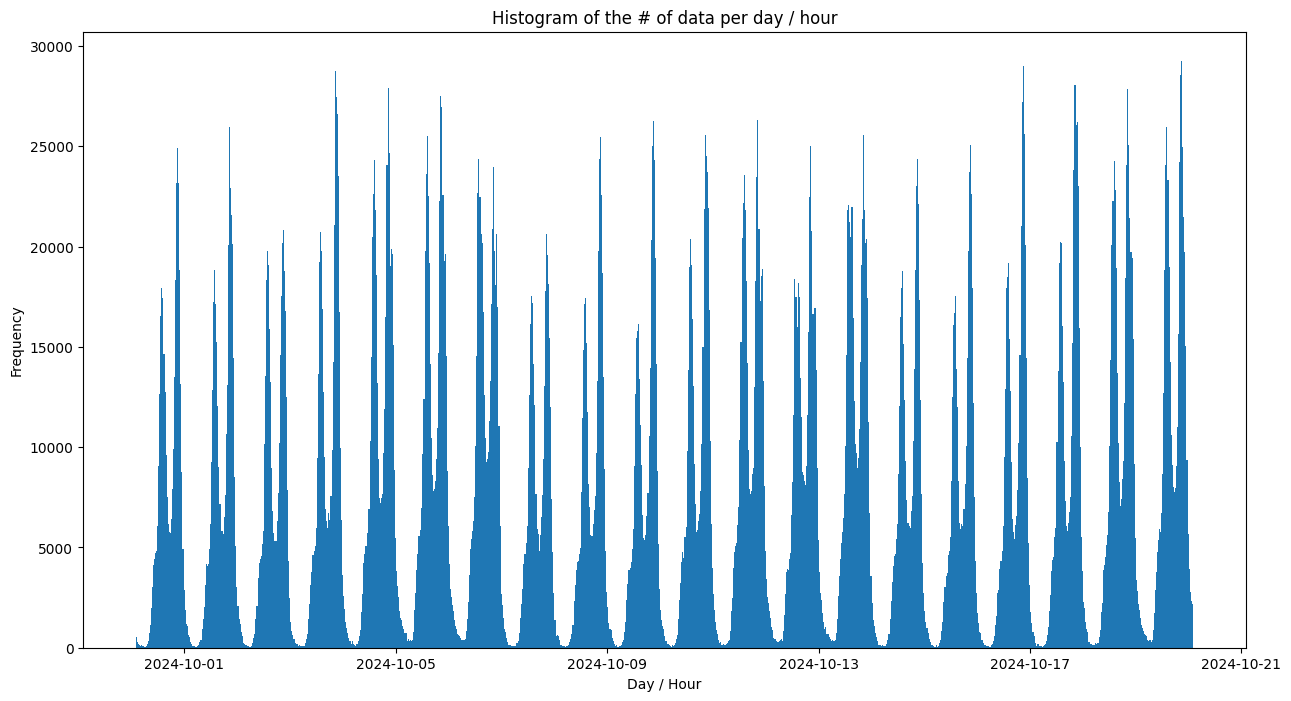

In [52]:
# Histogram of the # of data per day / hour
plt.figure(figsize=(15, 8))
plt.hist(data['creation_timestamp'], bins = 1000)
plt.title('Histogram of the # of data per day / hour')
plt.xlabel('Day / Hour')
plt.ylabel('Frequency')
plt.show()

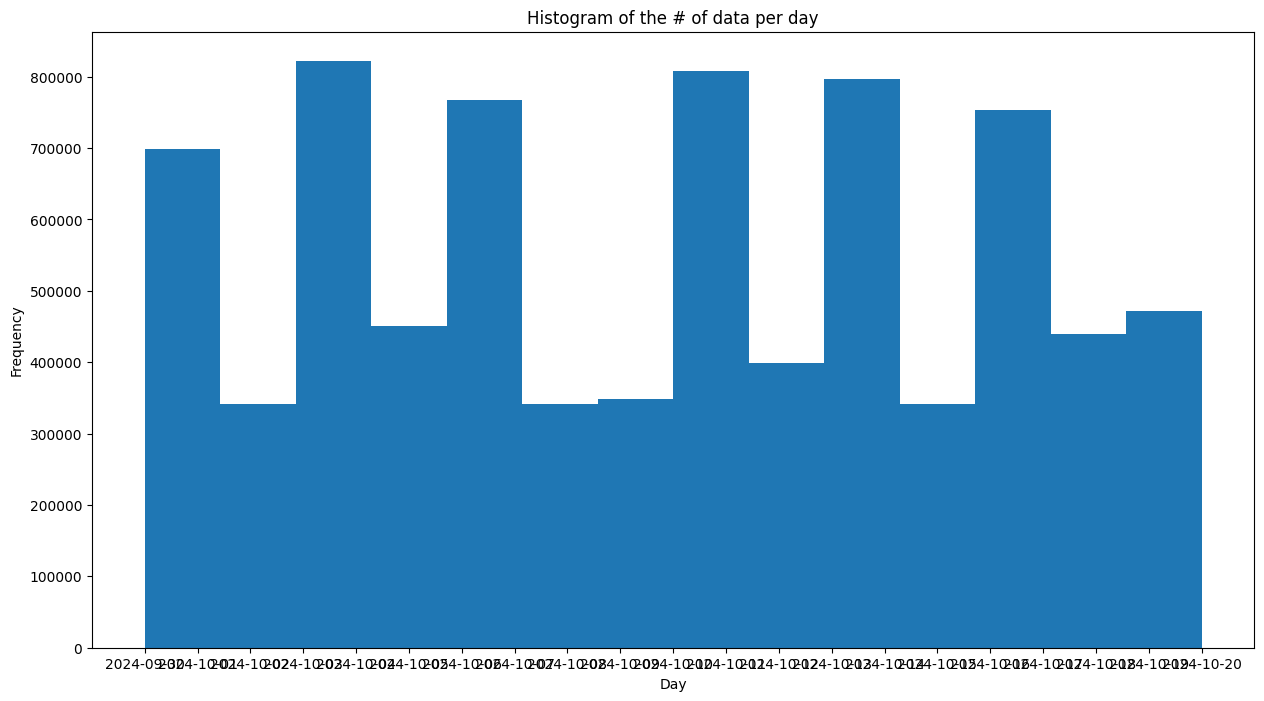

In [53]:
plt.figure(figsize=(15, 8))
plt.hist(data['creation_date'], bins = 14)
plt.title('Histogram of the # of data per day')
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.show()

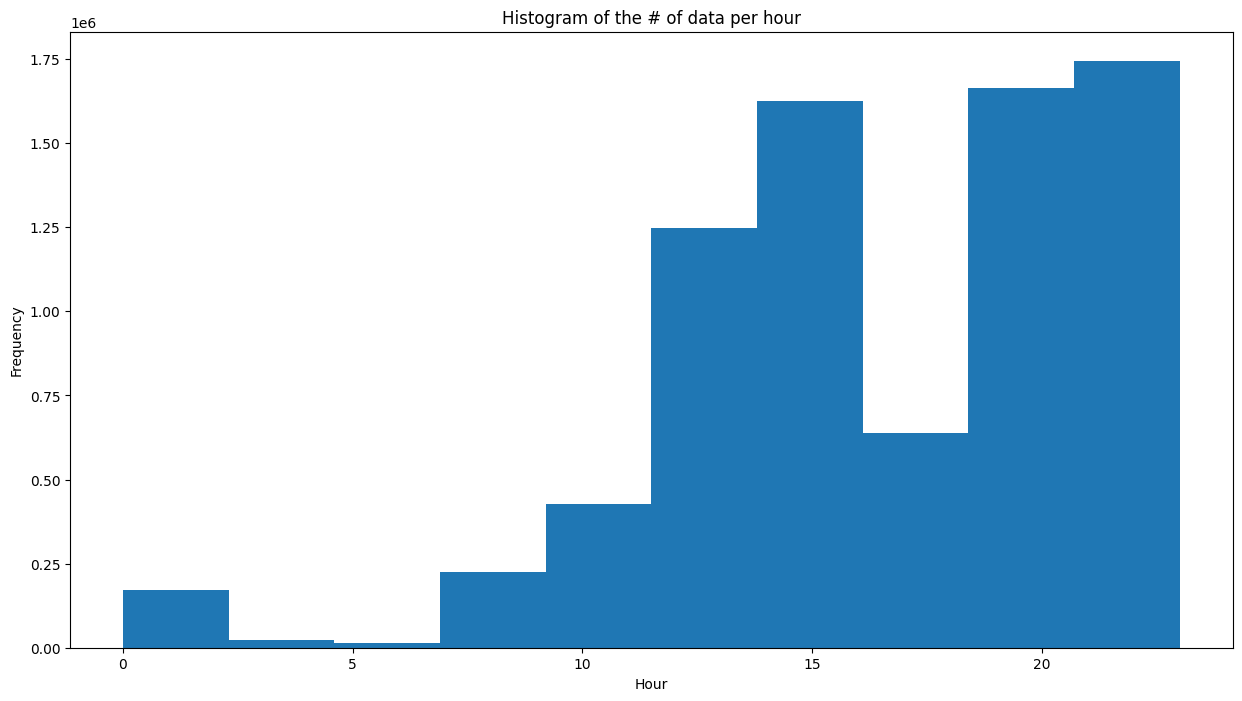

In [54]:
plt.figure(figsize=(15, 8))
plt.hist(data['creation_hour'])
plt.title('Histogram of the # of data per hour')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show()

In [55]:
# Check the distribution of the transport types
data['transport'].value_counts()

transport
BICYCLE      3690360
MOTORBIKE    3144808
CAR           940736
WALKER          3864
Name: count, dtype: int64

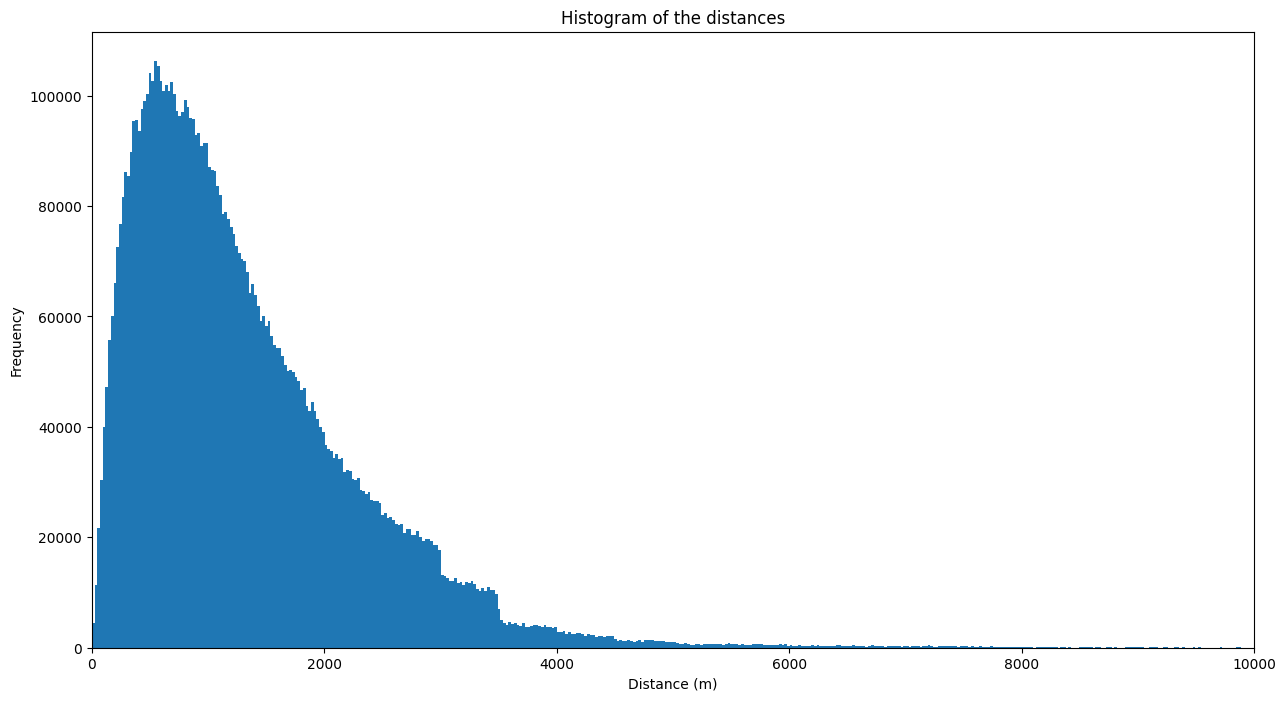

In [56]:
# Check the distribution of the distances
plt.figure(figsize=(15, 8))
plt.hist(data['pd_distance_haversine_m'], bins = 1000)
plt.xlim(0, 10000)
plt.title('Histogram of the distances')
plt.xlabel('Distance (m)')
plt.ylabel('Frequency')
plt.show()

## Hyperparameters

In [57]:
test_set_perc = 0.1
days_for_test = 7
k_cv = 5

## Database split

In [58]:
X = data
y = data['delivery_entering_timestamp'] - data['pickup_timestamp']
y = pd.Series(y, name='pickup_to_delivery')
y

4806.0    0 days 00:07:39.308000
4811.0    0 days 00:03:08.860000
4850.0    0 days 00:04:44.029000
4906.0    0 days 00:10:23.377000
4912.0    0 days 00:08:29.043000
                   ...          
68825.0   0 days 00:02:30.065000
69405.0   0 days 00:09:18.499000
69964.0   0 days 00:12:22.575000
70230.0   0 days 00:13:06.619000
70533.0   0 days 00:03:14.149000
Name: pickup_to_delivery, Length: 7779768, dtype: timedelta64[ns]

As we are dealing with a time-series dataset (orders are placed at different times), we will split the data based on the creation timestamp, leaving out the last 10% of the data for testing. This will help to understand the performance of the model on unseen data, as in reality we will have to test the model on data created on day+1 with respect to our training data.

In [59]:
X.sort_values('creation_timestamp', inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_perc, random_state=0)

In [60]:
X_train

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_timestamp,delivery_entering_timestamp,delivery_timestamp,pickup_latitude,...,creation_hour,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code
NaN,ES,100912945341,82116848,2024-10-06 04:39:51+00:00,2024-10-06 04:39:52+00:00,MOTORBIKE,2024-10-06 04:54:06.033000+00:00,2024-10-06 05:12:39+00:00,2024-10-06 05:15:51+00:00,40.405037,...,4,0.705201,-0.063836,0.705516,-0.064597,4197.904729,4197.904729,5699.771260,2024-10-06,MAD
18878.0,ES,100907445811,108374116,2024-10-03 20:43:09+00:00,2024-10-03 20:43:10+00:00,CAR,2024-10-03 20:58:26.182000+00:00,2024-10-03 21:02:33+00:00,2024-10-03 21:05:04+00:00,40.449734,...,20,NaN,NaN,NaN,NaN,1263.196587,74664.885804,1642.771209,2024-10-03,MAD
NaN,ES,100936177156,134731488,2024-10-16 16:30:55+00:00,2024-10-16 16:30:56+00:00,MOTORBIKE,2024-10-16 16:38:29.143000+00:00,2024-10-16 16:41:10+00:00,2024-10-16 16:43:44+00:00,40.435170,...,16,0.705727,-0.064146,0.705739,-0.064195,251.227543,251.227543,317.805477,2024-10-16,MAD
NaN,ES,100942773602,160541528,2024-10-19 15:23:48+00:00,2024-10-19 15:23:49+00:00,BICYCLE,2024-10-19 15:35:59.329000+00:00,2024-10-19 15:39:20+00:00,2024-10-19 15:40:59+00:00,40.430096,...,15,0.705638,-0.064653,0.705706,-0.064590,526.470464,526.470464,734.262801,2024-10-19,MAD
71594.0,ES,100918548292,31382174,2024-10-08 17:46:44+00:00,2024-10-08 17:46:45+00:00,BICYCLE,2024-10-08 17:52:59.464000+00:00,2024-10-08 17:57:39+00:00,2024-10-08 18:01:07+00:00,41.357826,...,17,0.721830,0.037159,0.721936,0.037038,889.905456,889.905456,1256.263593,2024-10-08,BCN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135.0,ES,100912560380,155116258,2024-10-05 21:47:58+00:00,2024-10-05 21:48:00+00:00,BICYCLE,2024-10-05 22:15:04.840000+00:00,2024-10-05 22:19:52+00:00,2024-10-05 22:26:19+00:00,40.467260,...,21,NaN,NaN,NaN,NaN,991.543508,69503.124596,1043.387128,2024-10-05,MAD
62153.0,ES,100929677286,92118362,2024-10-13 15:16:20+00:00,2024-10-13 15:16:22+00:00,BICYCLE,2024-10-13 15:27:50.553000+00:00,2024-10-13 15:31:01+00:00,2024-10-13 15:33:33+00:00,41.400146,...,15,0.722569,0.037281,0.722527,0.037187,521.237117,521.237117,714.775973,2024-10-13,BCN
5928.0,ES,100912376936,5210543,2024-10-05 21:04:08+00:00,2024-10-05 21:04:10+00:00,BICYCLE,2024-10-05 21:15:11.989000+00:00,2024-10-05 21:22:57+00:00,2024-10-05 21:26:36+00:00,41.375170,...,21,0.722133,0.037132,0.722153,0.037584,2165.387513,2165.387513,2289.644488,2024-10-05,BCN
75818.0,ES,100908284873,162934084,2024-10-04 12:31:17+00:00,2024-10-04 12:31:20+00:00,BICYCLE,2024-10-04 12:50:41.867000+00:00,2024-10-04 13:01:17+00:00,2024-10-04 13:05:15+00:00,40.461890,...,12,0.706193,-0.064378,0.706229,-0.063984,1922.659871,1922.659871,2141.409207,2024-10-04,MAD


In [61]:
y_train

64837.0   0 days 00:07:57.668000
24418.0   0 days 00:05:50.431000
80877.0   0 days 00:08:34.420000
88543.0   0 days 00:02:30.516000
44287.0   0 days 00:03:23.280000
                   ...          
35129.0   0 days 00:05:47.646000
97009.0   0 days 00:09:44.488000
15440.0   0 days 00:09:08.724000
50350.0   0 days 00:06:47.836000
66648.0   0 days 00:07:50.532000
Name: pickup_to_delivery, Length: 7001791, dtype: timedelta64[ns]

In [62]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7001791, 26) (7001791,)
(777977, 26) (777977,)


In [63]:
# In case we want to test different hyperparameters, we will use cross-validation
#scores = cross_val_score(<estimator>, X, y, cv=k_cv)

### Database split using directly the creation date

As we have partitioned the data by city and creation date, we can use this information to split the data. This will help to avoid data leakage, as we will not have data from the future in the training set.
This is much better than just sorting the data by the creation timestamp and taking 10% of the dataset as test set, as we did before.

In [64]:
# We take the last week of the dataset to test the model
begin_test_date = pd.to_datetime(end_date) - pd.Timedelta(days=days_for_test-1)
begin_test_date = begin_test_date.strftime("%Y-%m-%d")
print(f'Start date: {start_date} | Begin test date: {begin_test_date} | End date: {end_date}')

Start date: 2024-09-30 | Begin test date: 2024-10-14 | End date: 2024-10-20


In [65]:
X_train = pd.read_parquet("data/dataframe.parquet/", filters=[('creation_date', '<', begin_test_date)])
X_train.head()

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_timestamp,delivery_entering_timestamp,delivery_timestamp,pickup_latitude,...,creation_hour,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code
4806.0,ES,100901465337,169809943,2024-09-30 21:45:07+00:00,2024-09-30 21:45:08+00:00,MOTORBIKE,2024-09-30 22:00:36.692000+00:00,2024-09-30 22:08:16+00:00,2024-09-30 22:10:01+00:00,38.363853,...,21,0.669576,-0.008555,0.669944,-0.008598,2355.545318,2355.545318,2561.897200,2024-09-30,ALC
4811.0,ES,100901489101,9516729,2024-09-30 21:55:46+00:00,2024-09-30 21:55:47+00:00,CAR,2024-09-30 22:01:33.140000+00:00,2024-09-30 22:04:42+00:00,2024-09-30 22:09:18+00:00,38.367390,...,21,0.669637,-0.007405,0.669590,-0.007284,673.661802,673.661802,903.518684,2024-09-30,ALC
4850.0,ES,100899913152,172855743,2024-09-30 10:30:55+00:00,2024-09-30 10:30:57+00:00,MOTORBIKE,2024-09-30 10:41:24.971000+00:00,2024-09-30 10:46:09+00:00,2024-09-30 10:49:56+00:00,38.345226,...,10,0.669250,-0.008591,0.669252,-0.008468,614.688869,614.688869,622.462666,2024-09-30,ALC
4906.0,ES,100900447439,170201413,2024-09-30 14:46:15+00:00,2024-09-30 14:46:16+00:00,CAR,2024-09-30 14:56:29.623000+00:00,2024-09-30 15:06:53+00:00,2024-09-30 15:11:36+00:00,38.365310,...,14,0.669601,-0.008192,0.669539,-0.007604,2962.480499,2962.480499,3332.041363,2024-09-30,ALC
4912.0,ES,100900529830,176424631,2024-09-30 15:22:32+00:00,2024-09-30 15:22:33+00:00,MOTORBIKE,2024-09-30 15:44:46.957000+00:00,2024-09-30 15:53:16+00:00,2024-09-30 15:56:07+00:00,38.345670,...,15,0.669258,-0.008450,0.669258,-0.008792,1708.759794,1708.759794,1711.235976,2024-09-30,ALC


In [66]:
X_train.isnull().sum().sum()

np.int64(2712072)

In [67]:
X_train.isnull().sum()

country_code                        0
order_id                            0
courier_id                          0
creation_timestamp                  0
activation_timestamp                0
transport                           0
pickup_timestamp                    0
delivery_entering_timestamp         0
delivery_timestamp                  0
pickup_latitude                     0
pickup_longitude                    0
delivery_latitude                   0
delivery_longitude                  0
time_zone                           0
p_creation_date                     0
creation_time                       0
creation_hour                       0
pickup_latitude_rad            678018
pickup_longitude_rad           678018
delivery_latitude_rad          678018
delivery_longitude_rad         678018
pd_distance_haversine_m             0
pd_distance_haversine_m_sk          0
pd_distance_manhattan_m             0
creation_date                       0
city_code                           0
dtype: int64

In [68]:
y_train = X_train['delivery_entering_timestamp'] - X_train['pickup_timestamp']
y_train = pd.Series(y_train, name='pickup_to_delivery')
y_train

4806.0    0 days 00:07:39.308000
4811.0    0 days 00:03:08.860000
4850.0    0 days 00:04:44.029000
4906.0    0 days 00:10:23.377000
4912.0    0 days 00:08:29.043000
                   ...          
84190.0   0 days 00:04:27.832000
84192.0   0 days 00:05:29.981000
84663.0   0 days 00:12:19.778000
85111.0   0 days 00:08:33.237000
85969.0   0 days 00:09:04.232000
Name: pickup_to_delivery, Length: 5424144, dtype: timedelta64[ns]

In [69]:
y_train.isnull().sum().sum()

np.int64(0)

In [70]:
X_test = pd.read_parquet("data/dataframe.parquet", filters=[('creation_date', '>=', begin_test_date)])
X_test.head()

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_timestamp,delivery_entering_timestamp,delivery_timestamp,pickup_latitude,...,creation_hour,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code
9605.0,ES,100931299686,172175095,2024-10-14 00:09:32+00:00,2024-10-14 00:09:34+00:00,MOTORBIKE,2024-10-14 00:28:54.317000+00:00,2024-10-14 00:34:47+00:00,2024-10-14 00:36:48+00:00,38.382520,...,0,0.669901,-0.007882,0.669500,-0.008304,3310.852444,3310.852444,4665.700375,2024-10-14,ALC
14786.0,ES,100931323115,170201413,2024-10-14 00:50:44+00:00,2024-10-14 10:12:43+00:00,CAR,2024-10-14 10:36:43.867000+00:00,2024-10-14 10:48:41+00:00,2024-10-14 10:53:34+00:00,38.348476,...,0,0.669307,-0.008489,0.669187,-0.008794,1705.517814,1705.517814,2292.240241,2024-10-14,ALC
25221.0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,2024-10-14 23:40:38.323000+00:00,2024-10-14 23:45:02+00:00,2024-10-14 23:45:58+00:00,38.345078,...,23,0.669248,-0.008438,0.669327,-0.008516,636.152666,636.152666,893.835525,2024-10-14,ALC
25225.0,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,2024-10-14 23:50:58.351000+00:00,2024-10-15 00:03:18+00:00,2024-10-15 00:04:30+00:00,38.345078,...,23,0.669248,-0.008438,0.669202,-0.008581,774.114259,774.114259,1012.032964,2024-10-14,ALC
25277.0,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,2024-10-14 13:11:50.300000+00:00,2024-10-14 13:21:17+00:00,2024-10-14 13:22:05+00:00,38.361095,...,12,0.669527,-0.008637,0.669182,-0.008611,2205.902313,2205.902313,2337.577867,2024-10-14,ALC


In [71]:
X_test.isnull().sum().sum()

np.int64(1177812)

In [72]:
y_test = X_test['delivery_entering_timestamp'] - X_test['pickup_timestamp']
y_test = pd.Series(y_test, dtype=np.int64, name='pickup_to_delivery')
y_test

9605.0     352683000000
14786.0    717133000000
25221.0    263677000000
25225.0    739649000000
25277.0    566700000000
               ...     
68825.0    150065000000
69405.0    558499000000
69964.0    742575000000
70230.0    786619000000
70533.0    194149000000
Name: pickup_to_delivery, Length: 2355624, dtype: int64

In [73]:
y_test.isnull().sum().sum()

np.int64(0)

In [74]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5424144, 26) (5424144,)
(2355624, 26) (2355624,)


In [75]:
# check nan values
X_train.isnull().sum()

country_code                        0
order_id                            0
courier_id                          0
creation_timestamp                  0
activation_timestamp                0
transport                           0
pickup_timestamp                    0
delivery_entering_timestamp         0
delivery_timestamp                  0
pickup_latitude                     0
pickup_longitude                    0
delivery_latitude                   0
delivery_longitude                  0
time_zone                           0
p_creation_date                     0
creation_time                       0
creation_hour                       0
pickup_latitude_rad            678018
pickup_longitude_rad           678018
delivery_latitude_rad          678018
delivery_longitude_rad         678018
pd_distance_haversine_m             0
pd_distance_haversine_m_sk          0
pd_distance_manhattan_m             0
creation_date                       0
city_code                           0
dtype: int64

In [76]:
# print rows that have nulls
a = X_train[X_train.isnull().any(axis=1)]
a

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_timestamp,delivery_entering_timestamp,delivery_timestamp,pickup_latitude,...,creation_hour,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code
30737.0,ES,100899883502,166015865,2024-09-30 10:05:31+00:00,2024-09-30 10:05:34+00:00,CAR,2024-09-30 10:40:49+00:00,2024-09-30 10:53:48+00:00,2024-09-30 10:55:21+00:00,38.354984,...,10,NaN,NaN,NaN,NaN,2763.186813,160256.773776,3533.822837,2024-09-30,ALC
30788.0,ES,100900284118,157369264,2024-09-30 13:42:20+00:00,2024-09-30 13:42:21+00:00,MOTORBIKE,2024-09-30 13:51:19.082000+00:00,2024-09-30 13:57:26+00:00,2024-09-30 14:08:16+00:00,38.338870,...,13,NaN,NaN,NaN,NaN,1106.367198,64736.775491,1302.313007,2024-09-30,ALC
30829.0,ES,100900514765,176279014,2024-09-30 15:15:51+00:00,2024-09-30 15:15:53+00:00,MOTORBIKE,2024-09-30 15:40:37.175000+00:00,2024-09-30 15:46:09+00:00,2024-09-30 15:46:54+00:00,38.391617,...,15,NaN,NaN,NaN,NaN,1391.554868,78717.050870,1959.883768,2024-09-30,ALC
30831.0,ES,100900517471,173230048,2024-09-30 15:17:03+00:00,2024-09-30 15:17:04+00:00,MOTORBIKE,2024-09-30 15:38:09.114000+00:00,2024-09-30 15:46:26+00:00,2024-09-30 15:55:25+00:00,38.428850,...,15,NaN,NaN,NaN,NaN,4433.090322,242110.504770,5796.876236,2024-09-30,ALC
30835.0,ES,100900606611,165214923,2024-09-30 15:59:24+00:00,2024-09-30 15:59:26+00:00,CAR,2024-09-30 16:09:12.280000+00:00,2024-09-30 16:10:40+00:00,2024-09-30 16:11:30+00:00,38.344795,...,15,NaN,NaN,NaN,NaN,203.358663,11801.253034,281.024598,2024-09-30,ALC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84190.0,ES,100928671286,153689739,2024-10-13 00:28:02+00:00,2024-10-13 00:28:03+00:00,MOTORBIKE,2024-10-13 00:41:39.168000+00:00,2024-10-13 00:46:07+00:00,2024-10-13 00:47:31+00:00,37.378075,...,0,NaN,NaN,NaN,NaN,1025.783470,66127.090550,1441.614259,2024-10-13,SEV
84192.0,ES,100928694365,47322857,2024-10-13 01:01:47+00:00,2024-10-13 01:01:48+00:00,MOTORBIKE,2024-10-13 01:13:34.019000+00:00,2024-10-13 01:19:04+00:00,2024-10-13 01:19:57+00:00,37.387486,...,1,NaN,NaN,NaN,NaN,941.828214,62771.946428,1256.815499,2024-10-13,SEV
84663.0,ES,100928684412,161064501,2024-10-13 00:45:40+00:00,2024-10-13 00:45:41+00:00,MOTORBIKE,2024-10-13 00:48:59.222000+00:00,2024-10-13 01:01:19+00:00,2024-10-13 01:03:45+00:00,37.387287,...,0,NaN,NaN,NaN,NaN,2953.644386,183983.117770,4164.380647,2024-10-13,SEV
85111.0,ES,100928674045,116722332,2024-10-13 00:31:28+00:00,2024-10-13 00:31:30+00:00,BICYCLE,2024-10-13 00:38:09.763000+00:00,2024-10-13 00:46:43+00:00,2024-10-13 00:50:11+00:00,37.399765,...,0,NaN,NaN,NaN,NaN,1863.266164,126973.442730,2286.464880,2024-10-13,SEV


In [77]:
a['pickup_latitude_rad'] = np.radians(a['pickup_latitude'])
a['pickup_longitude_rad'] = np.radians(a['pickup_longitude'])
a['delivery_latitude_rad'] = np.radians(a['delivery_latitude'])
a['delivery_longitude_rad'] = np.radians(a['delivery_longitude'])
a

/var/folders/qp/z1bxlpj52x79nk6kr9rf00h40000gp/T/ipykernel_88977/3906174715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['pickup_latitude_rad'] = np.radians(a['pickup_latitude'])
/var/folders/qp/z1bxlpj52x79nk6kr9rf00h40000gp/T/ipykernel_88977/3906174715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['pickup_longitude_rad'] = np.radians(a['pickup_longitude'])
/var/folders/qp/z1bxlpj52x79nk6kr9rf00h40000gp/T/ipykernel_88977/3906174715.py:3: SettingWithCopyWarning: 
A value is trying to be set

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_timestamp,delivery_entering_timestamp,delivery_timestamp,pickup_latitude,...,creation_hour,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code
30737.0,ES,100899883502,166015865,2024-09-30 10:05:31+00:00,2024-09-30 10:05:34+00:00,CAR,2024-09-30 10:40:49+00:00,2024-09-30 10:53:48+00:00,2024-09-30 10:55:21+00:00,38.354984,...,10,0.669421,-0.008217,0.669275,-0.008738,2763.186813,160256.773776,3533.822837,2024-09-30,ALC
30788.0,ES,100900284118,157369264,2024-09-30 13:42:20+00:00,2024-09-30 13:42:21+00:00,MOTORBIKE,2024-09-30 13:51:19.082000+00:00,2024-09-30 13:57:26+00:00,2024-09-30 14:08:16+00:00,38.338870,...,13,0.669140,-0.009017,0.669173,-0.008800,1106.367198,64736.775491,1302.313007,2024-09-30,ALC
30829.0,ES,100900514765,176279014,2024-09-30 15:15:51+00:00,2024-09-30 15:15:53+00:00,MOTORBIKE,2024-09-30 15:40:37.175000+00:00,2024-09-30 15:46:09+00:00,2024-09-30 15:46:54+00:00,38.391617,...,15,0.670060,-0.008959,0.670198,-0.009175,1391.554868,78717.050870,1959.883768,2024-09-30,ALC
30831.0,ES,100900517471,173230048,2024-09-30 15:17:03+00:00,2024-09-30 15:17:04+00:00,MOTORBIKE,2024-09-30 15:38:09.114000+00:00,2024-09-30 15:46:26+00:00,2024-09-30 15:55:25+00:00,38.428850,...,15,0.670710,-0.006892,0.670976,-0.007713,4433.090322,242110.504770,5796.876236,2024-09-30,ALC
30835.0,ES,100900606611,165214923,2024-09-30 15:59:24+00:00,2024-09-30 15:59:26+00:00,CAR,2024-09-30 16:09:12.280000+00:00,2024-09-30 16:10:40+00:00,2024-09-30 16:11:30+00:00,38.344795,...,15,0.669243,-0.008452,0.669260,-0.008486,203.358663,11801.253034,281.024598,2024-09-30,ALC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84190.0,ES,100928671286,153689739,2024-10-13 00:28:02+00:00,2024-10-13 00:28:03+00:00,MOTORBIKE,2024-10-13 00:41:39.168000+00:00,2024-10-13 00:46:07+00:00,2024-10-13 00:47:31+00:00,37.378075,...,0,0.652370,-0.104744,0.652470,-0.104904,1025.783470,66127.090550,1441.614259,2024-10-13,SEV
84192.0,ES,100928694365,47322857,2024-10-13 01:01:47+00:00,2024-10-13 01:01:48+00:00,MOTORBIKE,2024-10-13 01:13:34.019000+00:00,2024-10-13 01:19:04+00:00,2024-10-13 01:19:57+00:00,37.387486,...,1,0.652535,-0.104622,0.652471,-0.104454,941.828214,62771.946428,1256.815499,2024-10-13,SEV
84663.0,ES,100928684412,161064501,2024-10-13 00:45:40+00:00,2024-10-13 00:45:41+00:00,MOTORBIKE,2024-10-13 00:48:59.222000+00:00,2024-10-13 01:01:19+00:00,2024-10-13 01:03:45+00:00,37.387287,...,0,0.652531,-0.104703,0.652888,-0.104330,2953.644386,183983.117770,4164.380647,2024-10-13,SEV
85111.0,ES,100928674045,116722332,2024-10-13 00:31:28+00:00,2024-10-13 00:31:30+00:00,BICYCLE,2024-10-13 00:38:09.763000+00:00,2024-10-13 00:46:43+00:00,2024-10-13 00:50:11+00:00,37.399765,...,0,0.652749,-0.104704,0.652673,-0.104349,1863.266164,126973.442730,2286.464880,2024-10-13,SEV


In [78]:
print(a.isnull().sum())

country_code                   0
order_id                       0
courier_id                     0
creation_timestamp             0
activation_timestamp           0
transport                      0
pickup_timestamp               0
delivery_entering_timestamp    0
delivery_timestamp             0
pickup_latitude                0
pickup_longitude               0
delivery_latitude              0
delivery_longitude             0
time_zone                      0
p_creation_date                0
creation_time                  0
creation_hour                  0
pickup_latitude_rad            0
pickup_longitude_rad           0
delivery_latitude_rad          0
delivery_longitude_rad         0
pd_distance_haversine_m        0
pd_distance_haversine_m_sk     0
pd_distance_manhattan_m        0
creation_date                  0
city_code                      0
dtype: int64


In [79]:
print(y_train.isnull().sum())

0


## Baseline Models

### BaselineModel_sum

In [80]:
model_bl_sum = BaselineModel_sum()
model_bl_sum.fit(X_train, y_train)

In [81]:
X_test_expanded = X_test.copy()
X_test_expanded['y_test_predicted'] = model_bl_sum.predict(X_test)
X_test_expanded['y_test'] = (X_test_expanded['delivery_entering_timestamp'] - X_test_expanded['pickup_timestamp']).dt.total_seconds()
X_test_expanded['diff'] = X_test_expanded['y_test_predicted'] - X_test_expanded['y_test']
X_test_expanded

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_timestamp,delivery_entering_timestamp,delivery_timestamp,pickup_latitude,...,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code,y_test_predicted,y_test,diff
9605.0,ES,100931299686,172175095,2024-10-14 00:09:32+00:00,2024-10-14 00:09:34+00:00,MOTORBIKE,2024-10-14 00:28:54.317000+00:00,2024-10-14 00:34:47+00:00,2024-10-14 00:36:48+00:00,38.382520,...,0.669500,-0.008304,3310.852444,3310.852444,4665.700375,2024-10-14,ALC,740.903890,352.683,388.220890
14786.0,ES,100931323115,170201413,2024-10-14 00:50:44+00:00,2024-10-14 10:12:43+00:00,CAR,2024-10-14 10:36:43.867000+00:00,2024-10-14 10:48:41+00:00,2024-10-14 10:53:34+00:00,38.348476,...,0.669187,-0.008794,1705.517814,1705.517814,2292.240241,2024-10-14,ALC,371.866705,717.133,-345.266295
25221.0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,2024-10-14 23:40:38.323000+00:00,2024-10-14 23:45:02+00:00,2024-10-14 23:45:58+00:00,38.345078,...,0.669327,-0.008516,636.152666,636.152666,893.835525,2024-10-14,ALC,70.327965,263.677,-193.349035
25225.0,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,2024-10-14 23:50:58.351000+00:00,2024-10-15 00:03:18+00:00,2024-10-15 00:04:30+00:00,38.345078,...,0.669202,-0.008581,774.114259,774.114259,1012.032964,2024-10-14,ALC,285.962146,739.649,-453.686854
25277.0,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,2024-10-14 13:11:50.300000+00:00,2024-10-14 13:21:17+00:00,2024-10-14 13:22:05+00:00,38.361095,...,0.669182,-0.008611,2205.902313,2205.902313,2337.577867,2024-10-14,ALC,32.686960,566.700,-534.013040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68825.0,ES,100944409080,147454989,2024-10-20 00:46:55+00:00,2024-10-20 00:46:56+00:00,MOTORBIKE,2024-10-20 01:01:08.935000+00:00,2024-10-20 01:03:39+00:00,2024-10-20 01:04:31+00:00,37.394580,...,NaN,NaN,422.299379,25245.687311,567.529529,2024-10-20,SEV,497.429384,150.065,347.364384
69405.0,ES,100944420353,176969361,2024-10-20 01:05:42+00:00,2024-10-20 01:05:43+00:00,MOTORBIKE,2024-10-20 01:30:10.501000+00:00,2024-10-20 01:39:29+00:00,2024-10-20 01:52:39+00:00,37.371475,...,NaN,NaN,3131.145748,211357.960688,3907.369182,2024-10-20,SEV,168.525163,558.499,-389.973837
69964.0,ES,100944376912,175206228,2024-10-20 00:06:02+00:00,2024-10-20 00:06:03+00:00,MOTORBIKE,2024-10-20 00:15:41.425000+00:00,2024-10-20 00:28:04+00:00,2024-10-20 00:30:14+00:00,37.378030,...,NaN,NaN,1338.584915,76882.004286,1474.909884,2024-10-20,SEV,324.976805,742.575,-417.598195
70230.0,ES,100944400312,174198829,2024-10-20 00:34:03+00:00,2024-10-20 00:34:04+00:00,BICYCLE,2024-10-20 00:37:07.381000+00:00,2024-10-20 00:50:14+00:00,2024-10-20 00:52:55+00:00,37.377640,...,NaN,NaN,2425.338748,148308.288934,3384.627931,2024-10-20,SEV,158.185789,786.619,-628.433211


In [82]:
model_bl_sum.predict(X_test.iloc[0])

0    1058.713967
Name: pickup_to_delivery_predicted, dtype: float64

### BaselineModel_mean

In [83]:
model_bl_mean = BaselineModel_mean()
model_bl_mean.fit(X_train, y_train)

In [84]:
X_test_expanded2 = X_test.copy()
X_test_expanded2['y_test_predicted'] = model_bl_mean.predict(X_test)
X_test_expanded2['y_test'] = (X_test_expanded2['delivery_entering_timestamp'] - X_test_expanded2['pickup_timestamp']).dt.total_seconds()
X_test_expanded2['diff'] = X_test_expanded2['y_test_predicted'] - X_test_expanded2['y_test']
X_test_expanded2

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_timestamp,delivery_entering_timestamp,delivery_timestamp,pickup_latitude,...,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code,y_test_predicted,y_test,diff
9605.0,ES,100931299686,172175095,2024-10-14 00:09:32+00:00,2024-10-14 00:09:34+00:00,MOTORBIKE,2024-10-14 00:28:54.317000+00:00,2024-10-14 00:34:47+00:00,2024-10-14 00:36:48+00:00,38.382520,...,0.669500,-0.008304,3310.852444,3310.852444,4665.700375,2024-10-14,ALC,1058.891232,352.683,706.208232
14786.0,ES,100931323115,170201413,2024-10-14 00:50:44+00:00,2024-10-14 10:12:43+00:00,CAR,2024-10-14 10:36:43.867000+00:00,2024-10-14 10:48:41+00:00,2024-10-14 10:53:34+00:00,38.348476,...,0.669187,-0.008794,1705.517814,1705.517814,2292.240241,2024-10-14,ALC,261.470911,717.133,-455.662089
25221.0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,2024-10-14 23:40:38.323000+00:00,2024-10-14 23:45:02+00:00,2024-10-14 23:45:58+00:00,38.345078,...,0.669327,-0.008516,636.152666,636.152666,893.835525,2024-10-14,ALC,61.473436,263.677,-202.203564
25225.0,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,2024-10-14 23:50:58.351000+00:00,2024-10-15 00:03:18+00:00,2024-10-15 00:04:30+00:00,38.345078,...,0.669202,-0.008581,774.114259,774.114259,1012.032964,2024-10-14,ALC,201.068775,739.649,-538.580225
25277.0,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,2024-10-14 13:11:50.300000+00:00,2024-10-14 13:21:17+00:00,2024-10-14 13:22:05+00:00,38.361095,...,0.669182,-0.008611,2205.902313,2205.902313,2337.577867,2024-10-14,ALC,22.983207,566.700,-543.716793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68825.0,ES,100944409080,147454989,2024-10-20 00:46:55+00:00,2024-10-20 00:46:56+00:00,MOTORBIKE,2024-10-20 01:01:08.935000+00:00,2024-10-20 01:03:39+00:00,2024-10-20 01:04:31+00:00,37.394580,...,NaN,NaN,422.299379,25245.687311,567.529529,2024-10-20,SEV,434.801344,150.065,284.736344
69405.0,ES,100944420353,176969361,2024-10-20 01:05:42+00:00,2024-10-20 01:05:43+00:00,MOTORBIKE,2024-10-20 01:30:10.501000+00:00,2024-10-20 01:39:29+00:00,2024-10-20 01:52:39+00:00,37.371475,...,NaN,NaN,3131.145748,211357.960688,3907.369182,2024-10-20,SEV,147.307276,558.499,-411.191724
69964.0,ES,100944376912,175206228,2024-10-20 00:06:02+00:00,2024-10-20 00:06:03+00:00,MOTORBIKE,2024-10-20 00:15:41.425000+00:00,2024-10-20 00:28:04+00:00,2024-10-20 00:30:14+00:00,37.378030,...,NaN,NaN,1338.584915,76882.004286,1474.909884,2024-10-20,SEV,284.061128,742.575,-458.513872
70230.0,ES,100944400312,174198829,2024-10-20 00:34:03+00:00,2024-10-20 00:34:04+00:00,BICYCLE,2024-10-20 00:37:07.381000+00:00,2024-10-20 00:50:14+00:00,2024-10-20 00:52:55+00:00,37.377640,...,NaN,NaN,2425.338748,148308.288934,3384.627931,2024-10-20,SEV,138.269664,786.619,-648.349336


In [85]:
model_bl_mean.predict(X_test.iloc[0])

0    744.414334
Name: pickup_to_delivery_predicted, dtype: float64

## Evaluation pipeline

In [86]:
model_bl_sum.evaluate(X_test, y_test)

(np.float64(452553676615.8744), np.float64(2.8705866566261753e+23))

In [87]:
model_bl_mean.evaluate(X_test, y_test)

(np.float64(452553676660.9587), np.float64(2.8705866570349458e+23))

## Linear Model

In [88]:
model_linear = LinearModel()
model_linear.fit(X_train, y_train)

ValueError: Input contains NaN

In [ ]:
X_test_expanded3 = X_test.copy()
X_test_expanded3['y_test_predicted'] = model_linear.predict(X_test)
X_test_expanded3['y_test'] = (X_test_expanded3['delivery_entering_timestamp'] - X_test_expanded3['pickup_timestamp']).dt.total_seconds()
X_test_expanded3['diff'] = X_test_expanded['y_test_predicted'] - X_test_expanded3['y_test']
X_test_expanded3

In [ ]:
model_linear.predict(X_test.iloc[0])

In [ ]:
model_linear.evaluate(X_test, y_test)